In [1]:
import pickle
import numpy as np
import os
import pandas as pd
from Folding_Functions import get_sense_with_flanks, calculate_avg_mfe_over_sense_region
from typing import Dict, Optional, Tuple
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
from asodesigner.util import get_antisense
from read_human_genome import get_locus_to_data_dict
from file_utils import read_human_genome_fasta_dict
from off_target_folding_functions import compute_offtarget_folding_feature, corr_and_scatter_df

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# PKL path under ASOdesign/scripts/data_genertion/off_target/
aso_pkl_path = os.path.join(
    project_root, 'scripts', 'data_genertion', 'off_target',
    'off_target_info.premRNA.top100.cutoff1200.pkl'
)

if not os.path.exists(aso_pkl_path):
    raise FileNotFoundError(f"PKL not found at: {aso_pkl_path}")

# load df_all
csv_path = os.path.join(project_root, 'scripts', 'data_genertion', 'data_asoptimizer_updated.csv')
df_all = pd.read_csv(csv_path)

/tmp/ipykernel_1379/3500814877.py:14: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(csv_path)


In [3]:
# Column name definitions from the ASO experiment dataset.
SEQUENCE = 'Sequence'
INHIBITION = 'Inhibition(%)'
CANONICAL_GENE = 'Canonical Gene Name'
CELL_LINE_ORGANISM = 'Cell line organism'
VOLUME = 'ASO_volume(nM)'
TREATMENT_PERIOD = 'Treatment_Period(hours)'
CELL_LINE = 'Cell_line'
TRANSFECTION = 'Transfection'
DENSITY = 'Density(cells/well)'
MODIFICATION = 'Modification'

Preprocessing ASO Experimental Dataset

In [4]:
# Remove rows with missing values in the INHIBITION column
all_data_no_nan = df_all.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001) #to avoid log 0
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')
# Load gene information from cache or generate it if needed
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)
# Filter data to keep only rows with valid gene information
df_all = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

In [5]:
SCORE_COL = "energy_w_by_exp_ARTH"  # change to a column as you like:
# ['energy', 'energy_w_by_exp_ARTH', 'energy_w_by_exp_GEO', 'energy_w_by_log_exp_ARTH', 'energy_w_by_log_exp_GEO', 'score']


In [6]:
df_all["cell_line_uniform"].unique()

array(['A431', 'NCI-H460', 'SH-SY5Y', 'Human IPS', 'KARPAS-229', 'MM.1R',
       'SK-MEL-28', 'H929', 'KMS11', 'SNU-449', 'HepaRG', 'Hela',
       'Human Neuronal Cell', 'U251', 'CC-2580', 'HepG2'], dtype=object)

In [9]:
df_all["cell_line_uniform"].value_counts()

cell_line_uniform
HepaRG                 6749
A431                   6683
HepG2                  4245
MM.1R                  3394
SK-MEL-28              2876
Human Neuronal Cell    1837
SH-SY5Y                1767
SNU-449                1119
KARPAS-229              987
CC-2580                 910
U251                    138
Hela                    128
H929                     73
KMS11                    52
Human IPS                24
NCI-H460                 18
Name: count, dtype: int64

In [ ]:
 '''"''cell_line2df_ = {
     'A431':A431_df,
     'A-431':A431_df,
     'NCI-H460':NCI_H460_df,
     'SH_SY5Y':SH_SY5Y_df,
     'SH-SY5Y':SH_SY5Y_df,
     'HeLa':HeLa_df,
     'Hela':HeLa_df,
     'HepG2':HepG2_df,
     'U-251MG':U_251MG_df,
     'U251':U_251MG_df
 }
 cellline_to_filename = {
    'A431': 'ACH-001328',
    'A-431': 'ACH-001328',
    'NCI-H460': 'ACH-000463',
    'SH_SY5Y': 'ACH-001188',
    'SH-SY5Y': 'ACH-001188',
    'HeLa': 'ACH-001086',
    'Hela': 'ACH-001086',
    'HepG2': 'ACH-000739',
    'U-251MG': 'ACH-000232',
    'U251': 'ACH-000232'
}'''

A431

In [8]:
# Filter df_all to A431 cell line
df_all_A  = df_all[df_all["Cell_line"].isin(["A431", "A-431"])].copy()
# Load the A431 transcriptome table (PRE-mRNA)
A431_df = pd.read_csv('ACH-001328.mutated_transcriptome_premRNA.merged.csv')

# Allowed ASO indices
allowed_asos_a431 = set(df_all_A["index"].unique()) #unique id's of asos from A431 cell line
print("Num ASOs in A431:", len(allowed_asos_a431))
print("Num ASOs in A431:", len(allowed_asos_a431))

# Load the big PKL and keep only entries for A431 cell line
# PKL path under ASOdesign/scripts/data_genertion/off_target/
aso_pkl_path = os.path.join(
    project_root, 'scripts', 'data_genertion', 'off_target',
    'off_target_info.premRNA.top100.cutoff1200.pkl')
with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)
# keep only keys (aso_idx) that are in df_all_A and are non-empty DataFrames
store_a431 = {k: v for k, v in store.items()
              if k in allowed_asos_a431 and isinstance(v, pd.DataFrame) and not v.empty}
cell_line2df_small_a431 = {
    "A431": A431_df,
    "A-431": A431_df,
    "ACH-001328": A431_df,
}
tmp_pkl_path_a431 = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.A431.tmp.pkl")
with open(tmp_pkl_path_a431, "wb") as f:
    pickle.dump(store_a431, f)
print(f"[DEBUG] Saved filtered PKL for A431: {tmp_pkl_path_a431} | entries={len(store_a431)}")
OUTPUT_CSV_A431 = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(),
                               "aso_offtarget_feature_A431.csv")


Num ASOs in A431: 6683
Num ASOs in A431: 6683
[DEBUG] Saved filtered PKL for A431: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.A431.tmp.pkl | entries=689


In [9]:
# Compute the feature
res_a431 = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_a431,
    df_all=df_all_A,
    cell_line2df=cell_line2df_small_a431,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_A431,
    verbose=True,
)
print(res_a431.head())


Saved: /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_A431.csv
Computed feature for 689 ASOs | skips: {'no_cell_line': 0, 'no_cl_df': 0, 'no_target_seq': 0, 'bad_bounds': 0}
   index cell_line  target  target_start  target_end  energy_w_by_exp_ARTH  \
0     85      A431  S100A2           352         361             -0.060040   
1    116      A431   RPS11           880         889             -0.069787   
2    163      A431   RPS20          1035        1046             -0.049586   
3    174      A431   RPS20          1035        1046             -0.049586   
4    175      A431   RPS20          1035        1046             -0.049586   

   mfe_offtarget  energy_w_by_exp_ARTH_overAbsMFE  \
0      -0.370471                         0.162063   
1      -0.290392                         0.240320   
2      -0.146962                         0.337406   
3      -0.146962                         0.337406   
4      -0.146962                         0.337406   

                        seq_co

n = 565
Pearson r = 0.099, p = 0.0183
Spearman r = 0.117, p = 0.00533


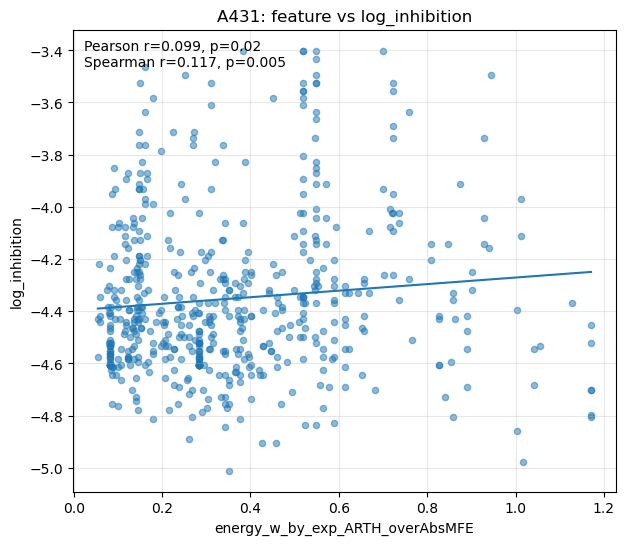

In [10]:
res_a431 = res_a431.rename(columns={"aso_idx": "index"})
stats, used = corr_and_scatter_df(
    df_feature=res_a431,
    df_all_subset=df_all_A,
    feature_col="energy_w_by_exp_ARTH_overAbsMFE",
    remove_outliers="iqr",
    iqr_k=1.5,
    title="A431: feature vs log_inhibition",
    save_path=None,  # או "corr_scatter_A431.png"
)

NCI-H460

In [11]:
CELL = "NCI-H460"
TRANSCRIPTOME_CSV = "ACH-000463.mutated_transcriptome_premRNA.merged.csv"

# Filter df_all to this cell line

df_all_NCI = df_all[df_all["Cell_line"] == CELL].copy()
print(f"[{CELL}] rows in df_all:", len(df_all_NCI))

# Load the transcriptome table (PRE-mRNA)
if not os.path.exists(TRANSCRIPTOME_CSV):
    raise FileNotFoundError(f"Missing transcriptome CSV: {TRANSCRIPTOME_CSV}")
NCI_H460_df = pd.read_csv(TRANSCRIPTOME_CSV, dtype=str, low_memory=False)

# Allowed ASO indices (cast to int safely)
allowed_asos_nci = set(pd.to_numeric(df_all_NCI["index"], errors="coerce").dropna().astype(int))
print(f"[{CELL}] unique ASOs:", len(allowed_asos_nci))

# Load the big PKL and keep only entries for this cell line
with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)

store_nci = {}
for k, v in store.items():
    try:
        kk = int(k)
    except Exception:
        continue
    if kk in allowed_asos_nci and isinstance(v, pd.DataFrame) and not v.empty:
        store_nci[kk] = v

tmp_pkl_path_nci = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.NCI-H460.tmp.pkl")
with open(tmp_pkl_path_nci, "wb") as f:
    pickle.dump(store_nci, f)
print(f"[DEBUG] Saved filtered PKL for {CELL}: {tmp_pkl_path_nci} | entries={len(store_nci)}")

# Map cell-line names/aliases to the transcriptome DataFrame
cell_line2df_small_nci = {
    "NCI-H460": NCI_H460_df,
    "NCI H460": NCI_H460_df,  # common alias, optional
    "H460": NCI_H460_df,  # optional
}

# Output file path
OUTPUT_CSV_NCI = os.path.join(os.getcwd(), "aso_offtarget_feature_NCI-H460.csv")

[NCI-H460] rows in df_all: 18
[NCI-H460] unique ASOs: 18
[DEBUG] Saved filtered PKL for NCI-H460: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.NCI-H460.tmp.pkl | entries=1


In [12]:
# Compute the feature
res_nci = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_nci,
    df_all=df_all_NCI,
    cell_line2df=cell_line2df_small_nci,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_NCI,
    verbose=True,
)
print(res_nci.head())

Saved: /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_NCI-H460.csv
Computed feature for 1 ASOs | skips: {'no_cell_line': 0, 'no_cl_df': 0, 'no_target_seq': 0, 'bad_bounds': 0}
   index cell_line target  target_start  target_end  energy_w_by_exp_ARTH  \
0    929  NCI-H460   PFN1          2539        2548             -0.031557   

   mfe_offtarget  energy_w_by_exp_ARTH_overAbsMFE  \
0      -0.215519                         0.146422   

                        seq_col  
0  Original Transcript Sequence  


SH-SY5Y

In [13]:
CELL = "SH-SY5Y"
TRANSCRIPTOME_CSV = "ACH-001188.mutated_transcriptome_premRNA.merged.csv"

df_all_SH = df_all[df_all["Cell_line"] == CELL].copy()
print(f"[{CELL}] rows in df_all:", len(df_all_SH))

if not os.path.exists(TRANSCRIPTOME_CSV):
    raise FileNotFoundError(f"Missing transcriptome CSV: {TRANSCRIPTOME_CSV}")
SH_SY5Y_df = pd.read_csv(TRANSCRIPTOME_CSV, dtype=str, low_memory=False)

allowed_asos_sh = set(pd.to_numeric(df_all_SH["index"], errors="coerce").dropna().astype(int))
print(f"[{CELL}] unique ASOs:", len(allowed_asos_sh))

with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)

store_sh = {}
for k, v in store.items():
    try:
        kk = int(k)
    except Exception:
        continue
    if kk in allowed_asos_sh and isinstance(v, pd.DataFrame) and not v.empty:
        store_sh[kk] = v

tmp_pkl_path_sh = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.SH-SY5Y.tmp.pkl")
with open(tmp_pkl_path_sh, "wb") as f:
    pickle.dump(store_sh, f)
print(f"[DEBUG] Saved filtered PKL for {CELL}: {tmp_pkl_path_sh} | entries={len(store_sh)}")

cell_line2df_small_sh = {
    "SH_SY5Y": SH_SY5Y_df,
    "SH-SY5Y": SH_SY5Y_df,  # alias
}

OUTPUT_CSV_SH = os.path.join(os.getcwd(), "aso_offtarget_feature_SH-SY5Y.csv")

[SH-SY5Y] rows in df_all: 1767
[SH-SY5Y] unique ASOs: 1767
[DEBUG] Saved filtered PKL for SH-SY5Y: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.SH-SY5Y.tmp.pkl | entries=284


In [14]:
res_sh = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_sh,
    df_all=df_all_SH,
    cell_line2df=cell_line2df_small_sh,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_SH,
    verbose=True,
)
print(res_sh.head())

Saved: /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_SH-SY5Y.csv
Computed feature for 284 ASOs | skips: {'no_cell_line': 0, 'no_cl_df': 0, 'no_target_seq': 0, 'bad_bounds': 0}
   index cell_line  target  target_start  target_end  energy_w_by_exp_ARTH  \
0    946   SH-SY5Y    RPS7           262         273             -0.243189   
1    954   SH-SY5Y    NACA          9423        9434             -0.053520   
2    957   SH-SY5Y  RPL13A          3092        3102             -0.072406   
3    958   SH-SY5Y   RPLP2          2640        2650             -0.056012   
4    973   SH-SY5Y   RPLP1           117         127             -0.048859   

   mfe_offtarget  energy_w_by_exp_ARTH_overAbsMFE  \
0      -0.427928                         0.568296   
1      -0.224837                         0.238037   
2      -0.233420                         0.310196   
3      -0.062097                         0.902013   
4      -0.195911                         0.249395   

                        seq

n = 272
Pearson r = -0.270, p = 6.52e-06
Spearman r = -0.285, p = 1.7e-06


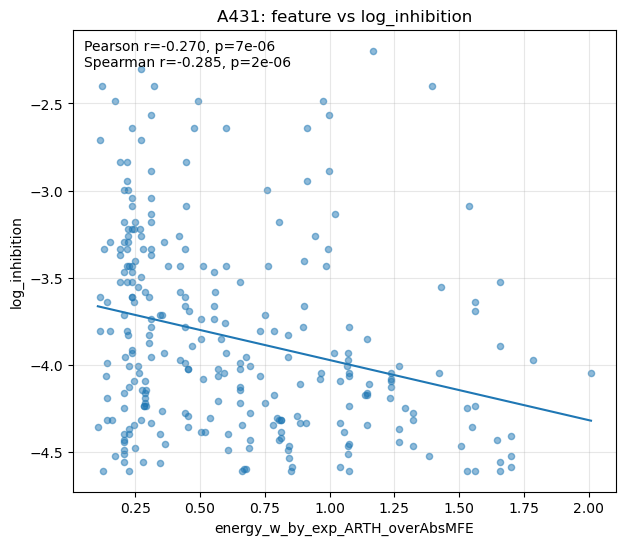

In [16]:
res_sh = res_sh.rename(columns={"aso_idx": "index"})
stats, used = corr_and_scatter_df(
    df_feature=res_sh,
    df_all_subset=df_all_SH,
    feature_col="energy_w_by_exp_ARTH_overAbsMFE",
    remove_outliers="iqr",
    iqr_k=1.5,
    title="SH-SY5Y: feature vs log_inhibition",
    save_path=None,
)

HeLa

In [7]:
CELL = "Hela"
TRANSCRIPTOME_CSV = "ACH-001086.mutated_transcriptome_premRNA.merged.csv"

df_all_HeLa = df_all[df_all["Cell_line"] == CELL].copy()
print(f"[{CELL}] rows in df_all:", len(df_all_HeLa))

if not os.path.exists(TRANSCRIPTOME_CSV):
    raise FileNotFoundError(f"Missing transcriptome CSV: {TRANSCRIPTOME_CSV}")
HeLa_df = pd.read_csv(TRANSCRIPTOME_CSV, dtype=str, low_memory=False)

allowed_asos_hela = set(pd.to_numeric(df_all_HeLa["index"], errors="coerce").dropna().astype(int))
print(f"[{CELL}] unique ASOs:", len(allowed_asos_hela))

with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)

store_hela = {}
for k, v in store.items():
    try:
        kk = int(k)
    except Exception:
        continue
    if kk in allowed_asos_hela and isinstance(v, pd.DataFrame) and not v.empty:
        store_hela[kk] = v

tmp_pkl_path_hela = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.HeLa.tmp.pkl")
with open(tmp_pkl_path_hela, "wb") as f:
    pickle.dump(store_hela, f)
print(f"[DEBUG] Saved filtered PKL for {CELL}: {tmp_pkl_path_hela} | entries={len(store_hela)}")

cell_line2df_small_hela = {
    "HeLa": HeLa_df,
    "Hela": HeLa_df,
    "HELA": HeLa_df,
}

OUTPUT_CSV_HeLa = os.path.join(os.getcwd(), "aso_offtarget_feature_HeLa.csv")


[Hela] rows in df_all: 128
[Hela] unique ASOs: 128
[DEBUG] Saved filtered PKL for Hela: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.HeLa.tmp.pkl | entries=0


In [11]:
res_hela = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_hela,
    df_all=df_all_HeLa,
    cell_line2df=cell_line2df_small_hela,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_HeLa,
    verbose=True,
)
print(res_hela.head())

Saved (empty): /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_HeLa.csv
Empty DataFrame
Columns: [aso_idx, cell_line, target, target_start, target_end, energy_w_by_exp_ARTH, mfe_offtarget, feature, seq_col]
Index: []


HepG2

In [17]:
CELL = "HepG2"
TRANSCRIPTOME_CSV = "ACH-000739.mutated_transcriptome_premRNA.merged.csv"

df_all_HepG2 = df_all[df_all["Cell_line"] == CELL].copy()
print(f"[{CELL}] rows in df_all:", len(df_all_HepG2))

if not os.path.exists(TRANSCRIPTOME_CSV):
    raise FileNotFoundError(f"Missing transcriptome CSV: {TRANSCRIPTOME_CSV}")
HepG2_df = pd.read_csv(TRANSCRIPTOME_CSV, dtype=str, low_memory=False)

allowed_asos_hepg2 = set(pd.to_numeric(df_all_HepG2["index"], errors="coerce").dropna().astype(int))
print(f"[{CELL}] unique ASOs:", len(allowed_asos_hepg2))

with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)

store_hepg2 = {}
for k, v in store.items():
    try:
        kk = int(k)
    except Exception:
        continue
    if kk in allowed_asos_hepg2 and isinstance(v, pd.DataFrame) and not v.empty:
        store_hepg2[kk] = v

tmp_pkl_path_hepg2 = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.HepG2.tmp.pkl")
with open(tmp_pkl_path_hepg2, "wb") as f:
    pickle.dump(store_hepg2, f)
print(f"[DEBUG] Saved filtered PKL for {CELL}: {tmp_pkl_path_hepg2} | entries={len(store_hepg2)}")

cell_line2df_small_hepg2 = {
    "HepG2": HepG2_df,
}

OUTPUT_CSV_HepG2 = os.path.join(os.getcwd(), "aso_offtarget_feature_HepG2.csv")

[HepG2] rows in df_all: 4245
[HepG2] unique ASOs: 4245
[DEBUG] Saved filtered PKL for HepG2: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.HepG2.tmp.pkl | entries=1434


In [13]:
res_hepg2 = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_hepg2,
    df_all=df_all_HepG2,
    cell_line2df=cell_line2df_small_hepg2,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_HepG2,
    verbose=True,
)
print(res_hepg2.head())

Saved: /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_HepG2.csv
Computed feature for 1434 ASOs | skips: {'no_cell_line': 0, 'no_cl_df': 0, 'no_target_seq': 0, 'bad_bounds': 0}
   index cell_line target  target_start  target_end  energy_w_by_exp_ARTH  \
0  29950     HepG2  RPL12           402         410             -0.021189   
1  30027     HepG2  RPL12           402         410             -0.021189   
2  30106     HepG2  RPL12           402         410             -0.021189   
3  30184     HepG2  RPL12           402         410             -0.021189   
4  30263     HepG2  RPL12           402         410             -0.021189   

   mfe_offtarget  energy_w_by_exp_ARTH_overAbsMFE  \
0      -0.379871                          0.05578   
1      -0.379871                          0.05578   
2      -0.379871                          0.05578   
3      -0.379871                          0.05578   
4      -0.379871                          0.05578   

                        seq_col  


n = 1379
Pearson r = 0.119, p = 9.75e-06
Spearman r = 0.149, p = 2.93e-08


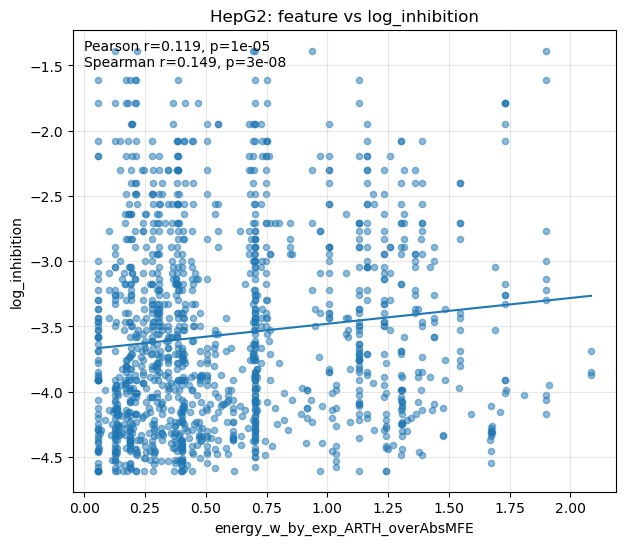

In [16]:
res_hepg2 = res_hepg2.rename(columns={"aso_idx": "index"})
stats, used = corr_and_scatter_df(
    df_feature=res_hepg2,
    df_all_subset=df_all_HepG2,
    feature_col="energy_w_by_exp_ARTH_overAbsMFE",
    remove_outliers="iqr",
    iqr_k=1.5,
    title="HepG2: feature vs log_inhibition",
    save_path=None,
)

U-251MG

In [18]:
CELL = "U251"
TRANSCRIPTOME_CSV = "ACH-000232.mutated_transcriptome_premRNA.merged.csv"

df_all_U251 = df_all[df_all["Cell_line"] == CELL].copy()
print(f"[{CELL}] rows in df_all:", len(df_all_U251))

if not os.path.exists(TRANSCRIPTOME_CSV):
    raise FileNotFoundError(f"Missing transcriptome CSV: {TRANSCRIPTOME_CSV}")
U_251MG_df = pd.read_csv(TRANSCRIPTOME_CSV, dtype=str, low_memory=False)

allowed_asos_u251 = set(pd.to_numeric(df_all_U251["index"], errors="coerce").dropna().astype(int))
print(f"[{CELL}] unique ASOs:", len(allowed_asos_u251))

with open(aso_pkl_path, "rb") as f:
    store = pickle.load(f)

store_u251 = {}
for k, v in store.items():
    try:
        kk = int(k)
    except Exception:
        continue
    if kk in allowed_asos_u251 and isinstance(v, pd.DataFrame) and not v.empty:
        store_u251[kk] = v

tmp_pkl_path_u251 = os.path.join(os.path.dirname(aso_pkl_path), "off_target_info.U-251MG.tmp.pkl")
with open(tmp_pkl_path_u251, "wb") as f:
    pickle.dump(store_u251, f)
print(f"[DEBUG] Saved filtered PKL for {CELL}: {tmp_pkl_path_u251} | entries={len(store_u251)}")

cell_line2df_small_u251 = {
    "U-251MG": U_251MG_df,
    "U251": U_251MG_df,  # aliases
    "U-251 MG": U_251MG_df,
    "U251MG": U_251MG_df,
}

OUTPUT_CSV_U251 = os.path.join(os.getcwd(), "aso_offtarget_feature_U-251MG.csv")

[U251] rows in df_all: 138
[U251] unique ASOs: 138
[DEBUG] Saved filtered PKL for U251: /home/idan/ASOdesign/scripts/data_genertion/off_target/off_target_info.U-251MG.tmp.pkl | entries=8


In [19]:
res_u251 = compute_offtarget_folding_feature(
    aso_pkl_path=tmp_pkl_path_u251,
    df_all=df_all_U251,
    cell_line2df=cell_line2df_small_u251,
    coords_are_1based_inclusive=True,
    flank_size=120, window_size=45, step=7,
    score_col=SCORE_COL,
    eps_min_abs_mfe=1e-6,
    output_csv=OUTPUT_CSV_U251,
    verbose=True,
)
print(res_u251.head())

Saved: /home/idan/ASOdesign/yehuda_code/aso_offtarget_feature_U-251MG.csv
Computed feature for 8 ASOs | skips: {'no_cell_line': 0, 'no_cl_df': 0, 'no_target_seq': 0, 'bad_bounds': 0}
   index cell_line  target  target_start  target_end  energy_w_by_exp_ARTH  \
0  28907      U251  EEF1A1         21669       21675             -0.142664   
1  28945      U251   SPARC           401         410             -0.068389   
2  28946      U251   SPARC           401         410             -0.068389   
3  28947      U251   SPARC           401         410             -0.068389   
4  28948      U251   SPARC           401         410             -0.068389   

   mfe_offtarget  energy_w_by_exp_ARTH_overAbsMFE  \
0      -0.267483                         0.533357   
1      -0.174725                         0.391409   
2      -0.174725                         0.391409   
3      -0.174725                         0.391409   
4      -0.174725                         0.391409   

                        seq_c

In [21]:
res_a431 = pd.read_csv('aso_offtarget_feature_A431.csv')
res_nci = pd.read_csv('aso_offtarget_feature_NCI-H460.csv')
res_sh = pd.read_csv('aso_offtarget_feature_SH-SY5Y.csv')

In [22]:
df_off_target_fold = pd.concat([res_a431,res_nci,res_sh,res_hepg2,res_u251], ignore_index=True)

In [23]:
df_off_target_fold

,index,cell_line,target,target_start,target_end,energy_w_by_exp_ARTH,mfe_offtarget,energy_w_by_exp_ARTH_overAbsMFE,seq_col
0,85,A431,S100A2,352,361,-0.060040,-0.370471,0.162063,Original Transcript Sequence
1,116,A431,RPS11,880,889,-0.069787,-0.290392,0.240320,Original Transcript Sequence
2,163,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence
3,174,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence
4,175,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence
...,...,...,...,...,...,...,...,...,...
2411,28947,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence
2412,28948,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence
2413,28949,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence
2414,28950,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence


In [24]:
cols = ["index", "log_inhibition"]
df_off_target_fold_merged = df_off_target_fold.merge(df_all[cols], on="index", how="inner")

In [25]:
df_off_target_fold_merged

,index,cell_line,target,target_start,target_end,energy_w_by_exp_ARTH,mfe_offtarget,energy_w_by_exp_ARTH_overAbsMFE,seq_col,log_inhibition
0,85,A431,S100A2,352,361,-0.060040,-0.370471,0.162063,Original Transcript Sequence,-3.970311
1,116,A431,RPS11,880,889,-0.069787,-0.290392,0.240320,Original Transcript Sequence,-4.174403
2,163,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-4.276680
3,174,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-4.127151
4,175,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-3.761223
...,...,...,...,...,...,...,...,...,...,...
2411,28947,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.304079
2412,28948,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.043069
2413,28949,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.158899
2414,28950,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.204708


In [26]:
df_off_target_fold_merged

,index,cell_line,target,target_start,target_end,energy_w_by_exp_ARTH,mfe_offtarget,energy_w_by_exp_ARTH_overAbsMFE,seq_col,log_inhibition
0,85,A431,S100A2,352,361,-0.060040,-0.370471,0.162063,Original Transcript Sequence,-3.970311
1,116,A431,RPS11,880,889,-0.069787,-0.290392,0.240320,Original Transcript Sequence,-4.174403
2,163,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-4.276680
3,174,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-4.127151
4,175,A431,RPS20,1035,1046,-0.049586,-0.146962,0.337406,Original Transcript Sequence,-3.761223
...,...,...,...,...,...,...,...,...,...,...
2411,28947,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.304079
2412,28948,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.043069
2413,28949,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.158899
2414,28950,U251,SPARC,401,410,-0.068389,-0.174725,0.391409,Original Transcript Sequence,-4.204708


n = 2229
Pearson r = 0.162, p = 1.17e-14
Spearman r = 0.194, p = 2.26e-20


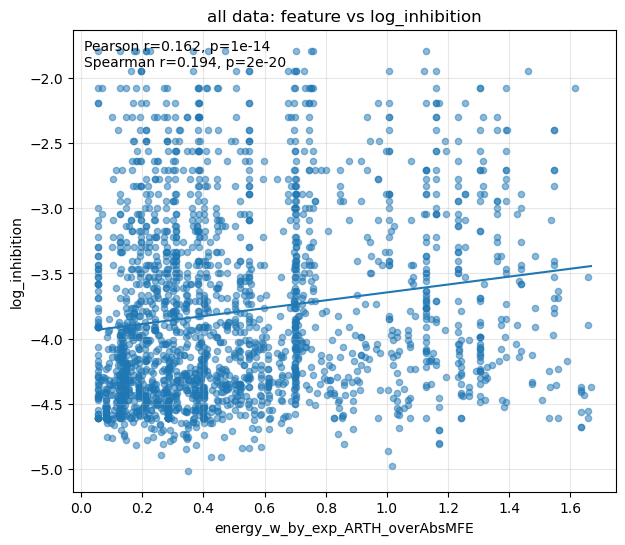

In [31]:
stats, used = corr_and_scatter_df(
    df_feature=df_off_target_fold_merged,
    df_all_subset=df_all,
    feature_col="energy_w_by_exp_ARTH_overAbsMFE",
    remove_outliers="iqr",
    iqr_k=1.5,
    title="all data: feature vs log_inhibition",
    save_path=None,
)